In [17]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

from src.models.ulosd_layers import FeatureMapsToKeyPoints, KeyPointsToFeatureMaps

12
torch.Size([1, 12, 128, 128])


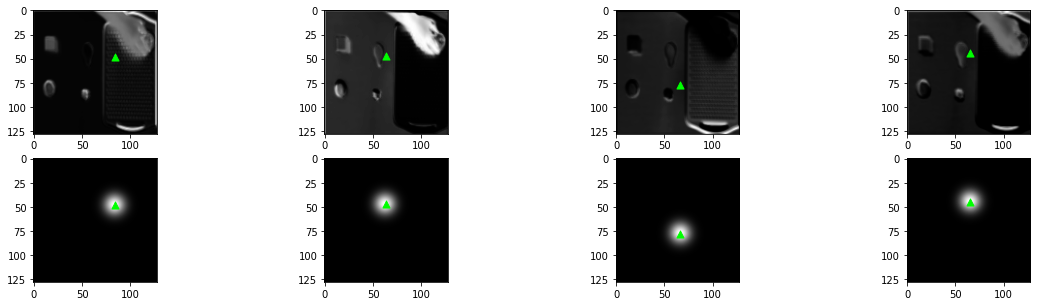

In [35]:
K = 3
W = 16
H = 16

# fmap = torch.rand((1, K, H, W))

K = 0
fmap = None

for _k in os.listdir("/home/yannik/vssil/test_feature_maps/"):
    if _k.startswith('source'):
        _fmap = torch.from_numpy(np.load(f"/home/yannik/vssil/test_feature_maps/{_k}")).unsqueeze(0).unsqueeze(0)
        K += 1
        fmap = _fmap if fmap is None else torch.cat([fmap, _fmap], axis=1)
        
print(K)
print(fmap.shape)
W, H = fmap.shape[-2:]

fmap2kpt = FeatureMapsToKeyPoints('cpu')
kpt2gmap = KeyPointsToFeatureMaps(15.0, W, 'cpu')

kpts = fmap2kpt(fmap) #  + ((torch.rand(1, K, 3) - 0.5)*2.0)
gmap = kpt2gmap(kpts)

# Distortions
"""
fmap[0, 0, ...] -= ((fmap[0, 1, ...] * 0.25) + (fmap[0, 2, ...] * 0.25))
fmap[0, 0, :, W-1] = 0.5
fmap = torch.softmax(fmap, dim=-2)
"""

kpts = fmap2kpt(fmap)
_K = 4
fig, ax = plt.subplots(2, _K, figsize=(20, 5))
for k in range(_K):
    ax[0, k].imshow(fmap[0, k, ...], cmap='gray')
    ax[1, k].imshow(gmap[0, k, ...], cmap='gray')
    w = ((-kpts[0, k, 1] + 1) / 2) * W
    h = ((kpts[0, k, 0] + 1) / 2) * H
    ax[0, k].scatter(w, h, s=50, c='lime', marker='^')
    ax[1, k].scatter(w, h, s=50, c='lime', marker='^')
# plt.tight_layout()
plt.show()

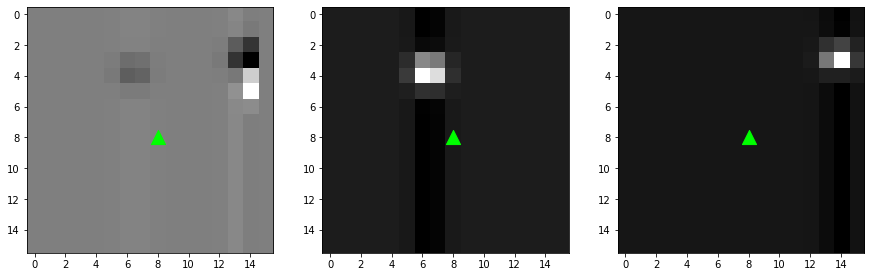

In [12]:
from src.models.transporter_keypointer import TransporterKeypointer

config = {
    'model': {
        'hidden_dim': 32,
        'num_img_channels': 3,
        'activation': 'LeakyReLU',
        'skip_connections': False,
        'num_keypoints': 3,
        'gaussian_map_std': 1.5
    },
    'device': 'cpu'
}

kpter = TransporterKeypointer(config)

transporter_kpts, gmaps = kpter.feature_maps_to_keypoints(fmap)

fig, ax = plt.subplots(1, K, figsize=(15, 5))
for k in range(K):
    ax[k].imshow(fmap[0, k, ...], cmap='gray')
    w = ((-transporter_kpts[0, k, 1] + 1) / 2) * W
    h = ((transporter_kpts[0, k, 0] + 1) / 2) * H
    ax[k].scatter(w, h, s=200, c='lime', marker='^')
plt.show()

In [13]:
print(fmap.shape)

torch.Size([1, 3, 16, 16])


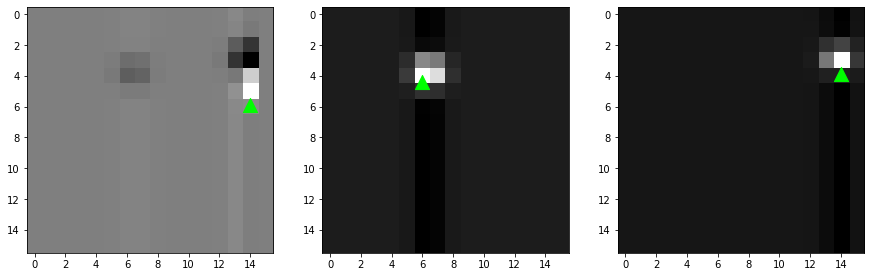

In [14]:
fig, ax = plt.subplots(1, K, figsize=(15, 5))
for k in range(K):
    ax[k].imshow(fmap[0, k, ...], cmap='gray')
    maxloc = torch.argmax(fmap[0, k, ...])
    h = maxloc/H
    w = maxloc%W
    ax[k].scatter(w, h, s=200, c='lime', marker='^')
plt.show()